In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score

sns.set_palette("rocket")


from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, EfficientSU2
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.circuit.library import QNNCircuit

from qiskit_aer.primitives import Sampler as SamplerAer

algorithm_globals.random_seed = 53


In [2]:
data = pd.read_csv("ad_click_dataset.csv")

In [3]:
data = data.drop(["full_name","gender"], axis=1)

In [4]:
data.shape

(10000, 7)

In [5]:
data.head()

,id,age,device_type,ad_position,browsing_history,time_of_day,click
0,670,22.0,Desktop,Top,Shopping,Afternoon,1
1,3044,NaN,Desktop,Top,NaN,NaN,1
2,5912,41.0,NaN,Side,Education,Night,1
3,5418,34.0,NaN,NaN,Entertainment,Evening,1
4,9452,39.0,NaN,NaN,Social Media,Morning,0


In [6]:
data = data.dropna()
data.head()

,id,age,device_type,ad_position,browsing_history,time_of_day,click
0,670,22.0,Desktop,Top,Shopping,Afternoon,1
17,188,56.0,Tablet,Bottom,News,Morning,1
19,7335,24.0,Tablet,Side,Entertainment,Night,0
21,2272,52.0,Tablet,Bottom,News,Morning,1
25,4890,43.0,Tablet,Bottom,Education,Afternoon,1


In [7]:
def count_clicks(data, col):
    df = pd.DataFrame(columns=[col, 'total'])
    unique_vals = data[col].unique().tolist()
    
    for i,val in enumerate(unique_vals):
        total = data.loc[data[col] == val]['click'].sum()
        df.loc[i] = { col:val, "total":total}

    df = df.sort_values(by=[col])
    return df
        

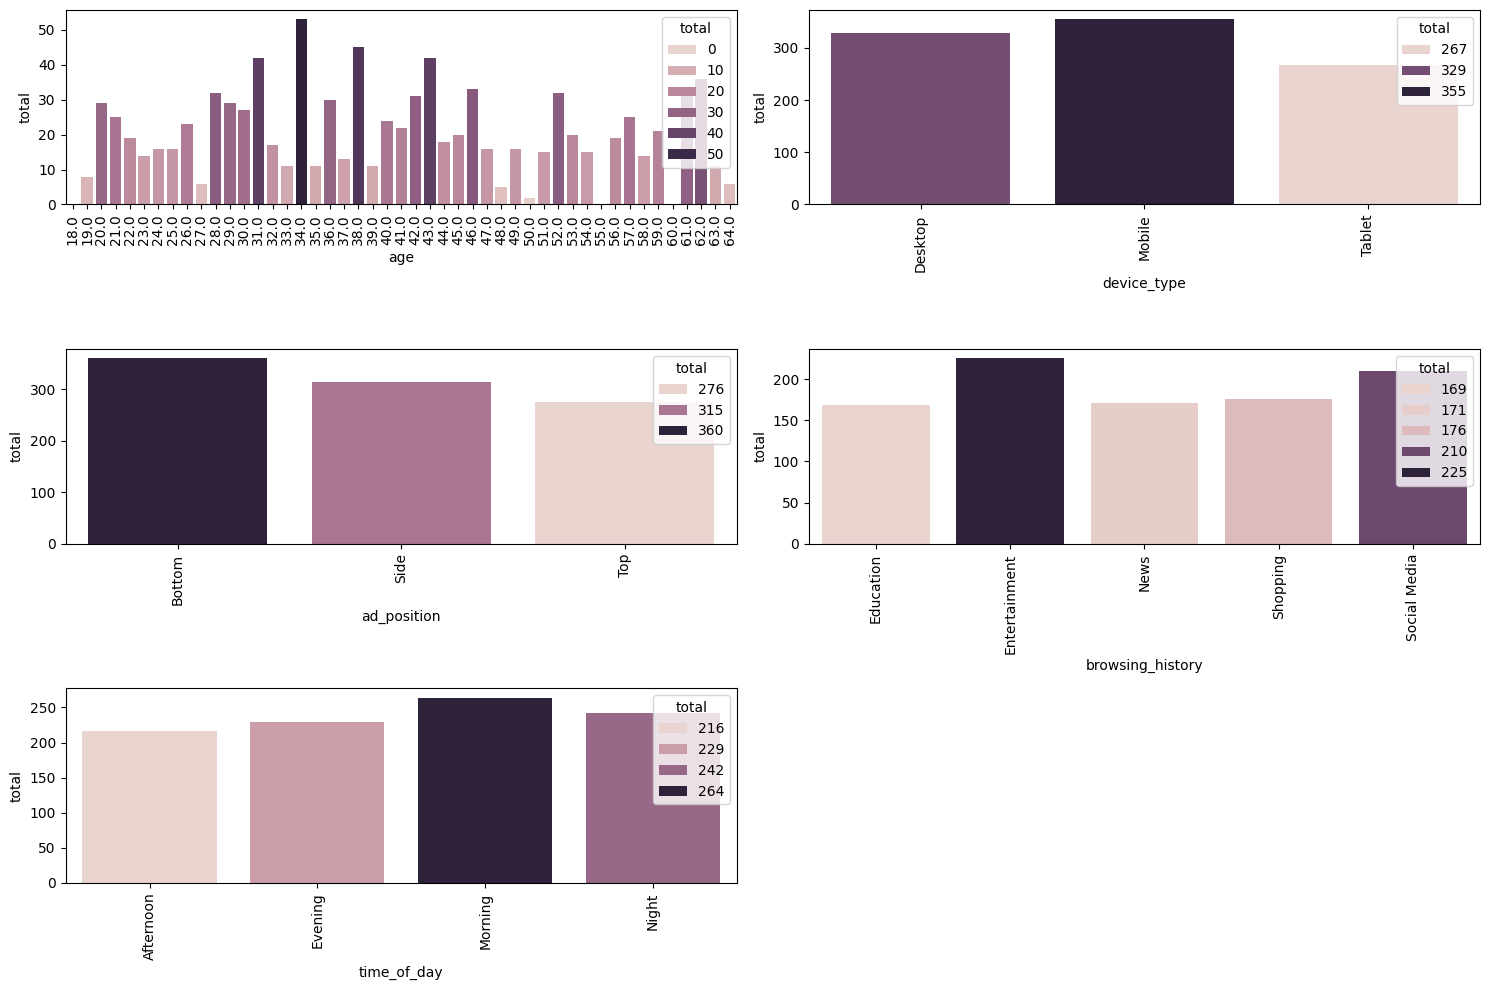

In [8]:
fig,axs = plt.subplots(3,2, figsize=(15, 10))
subplots = [ axs[i][j] for i in range(3) for j in range(2) ]
cols = ['age', 'device_type', 'ad_position', 'browsing_history', 'time_of_day', None]


for ax, col in zip(subplots, cols):
    if(not col):
        break

    cliks_by_col = count_clicks(data, col)
    sns.barplot(data=cliks_by_col, x=col, y="total", hue='total',ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.delaxes(subplots[-1])

fig.tight_layout()
plt.show()

In [9]:
data['browsing_history'] = data['browsing_history'].replace(['Education', 'News', 'Shopping'], 'Other')

In [10]:
def encode_columns(data, column):
    encoder = LabelEncoder()
    new_series = encoder.fit_transform(data[column].tolist())
    data[column] = new_series
    return data

In [11]:
data = encode_columns(data, "device_type")
data = encode_columns(data, "ad_position")
data = encode_columns(data, "browsing_history")
data = encode_columns(data, "time_of_day")
data.head()

,id,age,device_type,ad_position,browsing_history,time_of_day,click
0,670,22.0,0,2,1,0,1
17,188,56.0,2,0,1,2,1
19,7335,24.0,2,1,0,3,0
21,2272,52.0,2,0,1,2,1
25,4890,43.0,2,0,1,0,1


In [12]:
target = "click"
labels = ["age", "device_type", "ad_position", "browsing_history", "time_of_day"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data[labels], data[target], test_size=0.20, random_state=73)

In [14]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [15]:
y_pred = model.predict(X_test)

In [16]:
error = mean_squared_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)*100
print(f"error: {error:.10f}; accuracy: {accuracy:.2f}%")

error: 0.1283783784; accuracy: 87.16%


In [17]:
print(f"test: {y_test[20:30].tolist()}")
print(f"pred: {list(y_pred[20:30])}")

test: [0, 1, 0, 0, 1, 1, 1, 0, 1, 0]
pred: [0, 1, 1, 0, 1, 1, 1, 1, 1, 0]


---

In [18]:
features_dim = len(labels)
feature_map = ZZFeatureMap(feature_dimension=features_dim, reps=1)
ansatz = EfficientSU2(num_qubits=features_dim, reps=5, su2_gates=['rx', 'rz'])

In [19]:
sampler = SamplerAer()

In [20]:
opt = COBYLA(maxiter=100)

In [21]:
model = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=opt,
    callback=lambda w,e: print(f"evaluation: {e}")
)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data[labels], data[target], test_size=0.20, random_state=73)

In [23]:
model.fit(X_train.values, y_train.values)

evaluation: 0.9949492329616165
evaluation: 0.992881330470309
evaluation: 1.0221890201786832
evaluation: 1.008501236874048
evaluation: 1.0039077488784987
evaluation: 1.0120148017138915
evaluation: 0.9848209632648094
evaluation: 0.9876279492656471
evaluation: 0.9829187469155841
evaluation: 0.9949477084481959
evaluation: 0.9870862771552457
evaluation: 0.9700913200925197
evaluation: 0.9860008768699778
evaluation: 0.9746077042684576
evaluation: 0.9761018450962008
evaluation: 0.9834545711277793
evaluation: 0.9981373847033741
evaluation: 0.9834463033159349
evaluation: 0.9764388552886503
evaluation: 0.9696451633303453
evaluation: 0.9691338084520764
evaluation: 0.9889372068538719
evaluation: 0.9805180850963905
evaluation: 0.9755308280364308
evaluation: 0.9897210741234608
evaluation: 0.9764089581780407
evaluation: 0.9951184886784249
evaluation: 0.9745137508269816
evaluation: 0.974230053710029
evaluation: 0.9817658546973363
evaluation: 0.9791049749891345
evaluation: 0.997281215399013
evaluation: 

In [24]:
y_pred = model.predict(X_test)

In [25]:
accuracy_score(y_pred, y_test)*100

63.17567567567568

In [26]:
y_pred[:10], y_test[:10].tolist()

(array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0]), [1, 1, 1, 0, 1, 1, 1, 1, 0, 0])

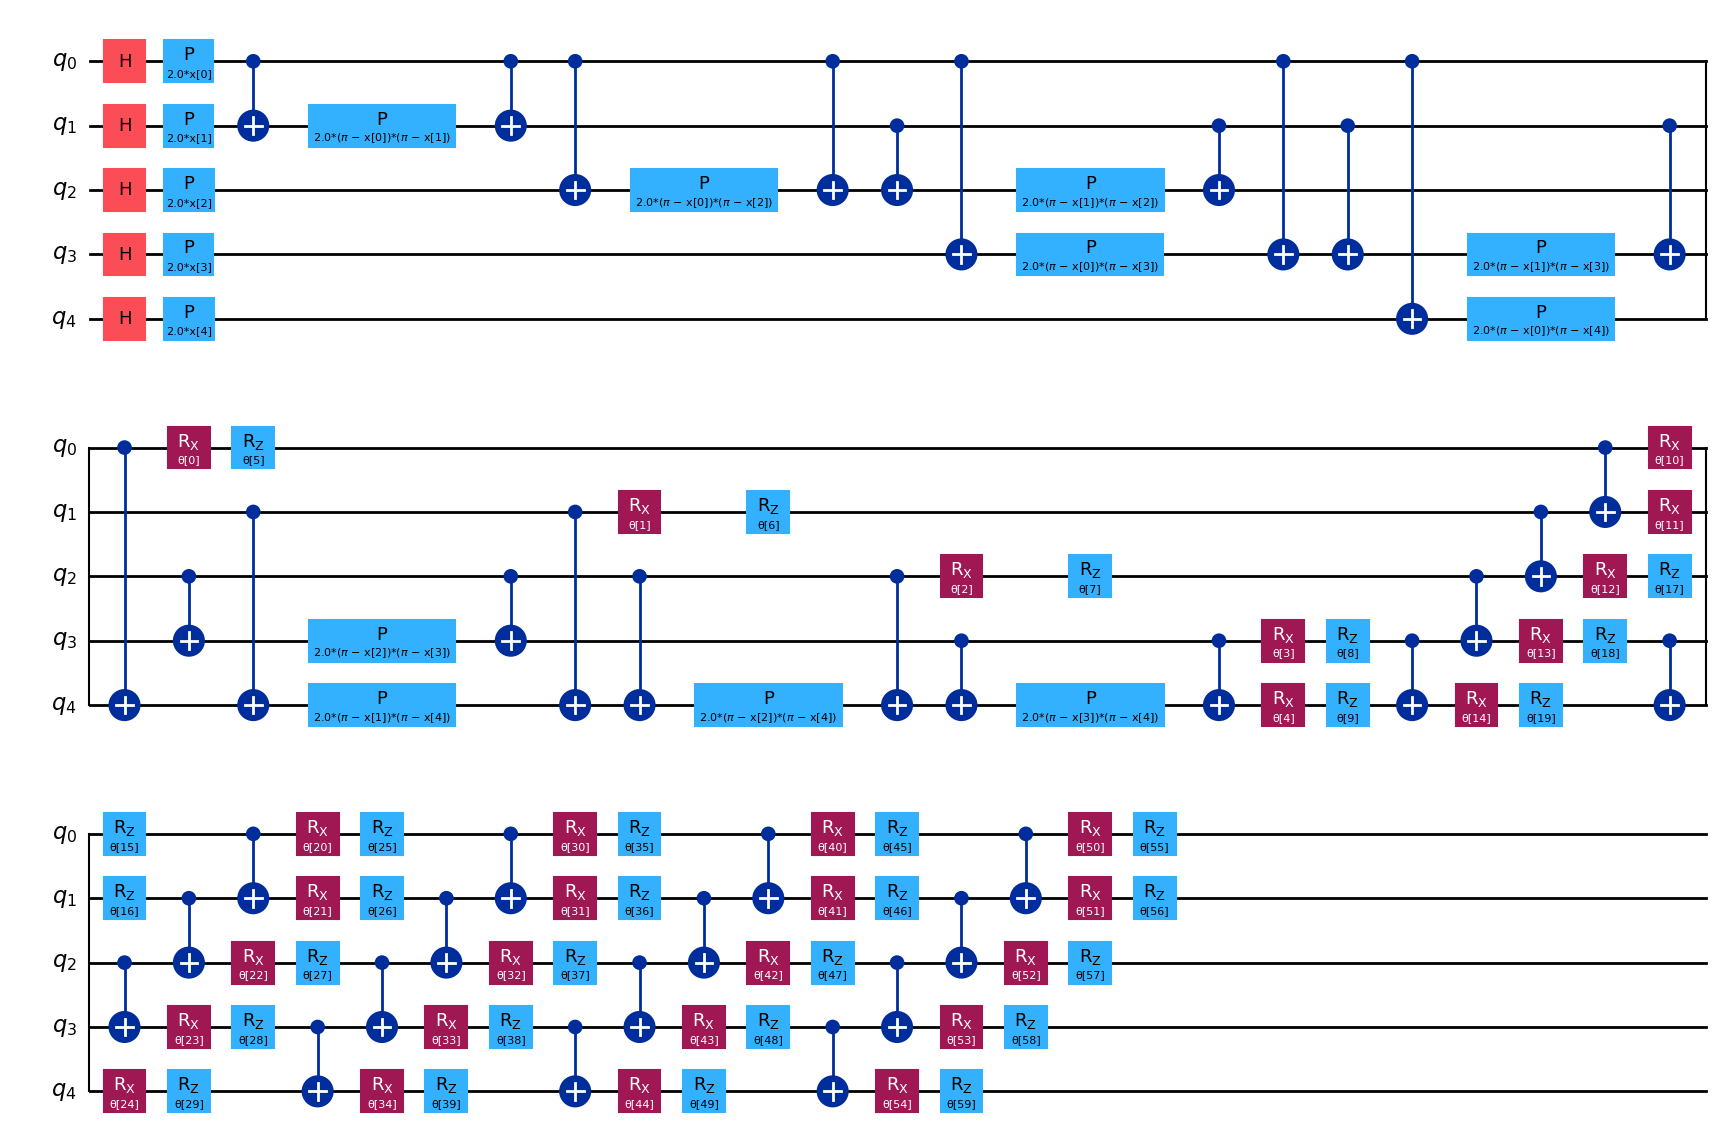

In [30]:
model.circuit.decompose().draw('mpl')

In [32]:
model.save("best_model")